## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)
import seaborn as sb
import statsmodels.api as sm

In [3]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
len(df[(df['group'] == 'treatment') & (df['landing_page'] != "new_page")])

1965

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum().sum()

0

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df1 = df.drop(df[(df['group'] == 'treatment') & (df['landing_page'] != "new_page")].index)
df2 = df1.drop(df[(df['group'] == 'control') & (df['landing_page'] != 'old_page')].index)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2.duplicated('user_id' ).sum()
df2[df2.duplicated('user_id' )]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

user with user id : 2893 is a duplicate user

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [12]:
df2.drop(index = 2893 , axis = 0, inplace = True)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [13]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [14]:
df2.groupby('group').mean().converted

group
control      0.120386
treatment    0.118808
Name: converted, dtype: float64

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [15]:
df2.groupby(df['group'] == 'treatment').mean().converted

group
False    0.120386
True     0.118808
Name: converted, dtype: float64

d. What is the probability that an individual received the new page?

In [16]:
df2[df2['landing_page'] == 'new_page'].count()/ len(df2['landing_page'])

user_id         0.500062
timestamp       0.500062
group           0.500062
landing_page    0.500062
converted       0.500062
dtype: float64

to know the period of time that the test has been taken

In [17]:
df2.timestamp.min() , df2.timestamp.max()

('2017-01-02 13:42:05.378582', '2017-01-24 13:41:54.460509')

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Your answer goes here.**
no there is not suffient eividence that  experiment for new page leads to more convetion as 11.9% and the contol group converted ratio is 12% it seems very close ratio  within 22 days

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**
$$H_0: CR_{P-old} - CR_{P-new} >= 0 $$
$$H_1: CR_{P-old} - CR_{P-new} < 0 $$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
cr_new = df2[df['landing_page'] == 'new_page']['converted'].mean()
cr_new

C:\Users\Pc\AppData\Local\Temp/ipykernel_2052/2076404034.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cr_new = df2[df['landing_page'] == 'new_page']['converted'].mean()


0.11880806551510564

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
cr_old = df2[df['landing_page'] == 'old_page']['converted'].mean()
cr_old

C:\Users\Pc\AppData\Local\Temp/ipykernel_2052/2481517269.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cr_old = df2[df['landing_page'] == 'old_page']['converted'].mean()


0.1203863045004612

c. What is $n_{new}$?

In [20]:
n_new = len(df2[df2['landing_page'] == "new_page"])
n_new

145310

d. What is $n_{old}$?

In [21]:
n_old = len(df2[df2['landing_page'] == "old_page"])
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.choice([1,0], size = n_new, p = [cr_new, 1-cr_new])

p_new = new_page_converted.mean()
p_new

0.11926914871653706

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.choice([1,0], size = n_old, p = [cr_old , 1-cr_old ] )

p_old = old_page_converted.mean()
p_old

0.11969106653633824

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
p_new - p_old

-0.00042191781980117915

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [25]:
p_diffs = []
for _ in range (10000):
    new_page = np.random.choice([1,0], size = n_new, p = [cr_new, 1-cr_new]).mean()
    old_page = np.random.choice([1,0], size = n_old, p = [cr_old , 1-cr_old ]).mean()
    p_diffs.append(new_page - old_page)

    
    

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

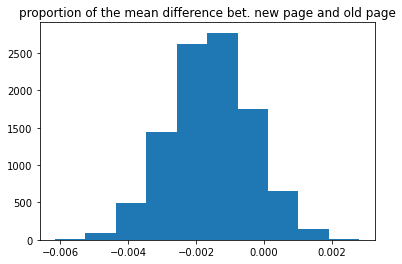

In [26]:
plt.hist(p_diffs);
plt.title ('proportion of the mean difference bet. new page and old page');


j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
p_diffs = np.array(p_diffs)


In [28]:
obs_new = df2.query(' landing_page == "new_page"').converted.mean()
obs_old = df2.query(' landing_page == "old_page"').converted.mean()
obs_diff = obs_new - obs_old
obs_diff

-0.0015782389853555567

In [29]:
null_val = np.random.normal(0 , p_diffs.std() , df2.size)


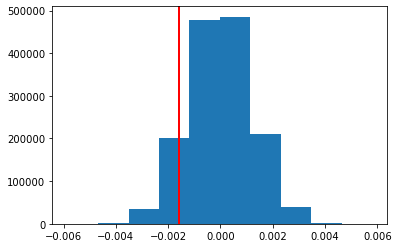

In [33]:
#null_mean = 0
obs_val = obs_diff
#high = null_mean + (null_mean - obs_diff)
plt.hist(null_val);
plt.axvline(obs_val , color = 'r' , linewidth = 2);
#plt.axvline(high , color = 'r' , linewidth = 2);

In [34]:
p_value = (null_val > obs_val).mean() 
p_value

0.9034757591608623

In [35]:
np.percentile(p_diffs , 2.5) , np.percentile( p_diffs ,97.5)

(-0.0039596271411632316, 0.0007622513701945531)

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Put your answer here.**

Fail to reject the null there is no significant difference between new and old pages and our data comes from null distribution  p-value is 0.90 
and observed mean is between confidence interval : (-0.003884058526139137, 0.0007759516506487444) 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [37]:
import statsmodels.api as sm

convert_old = df2.query('(landing_page == "old_page") & (converted == 1 )').count()[0]
convert_new = df2.query('(landing_page == "new_page") & (converted == 1 )').count()[0]
n_old = df2.query('landing_page == "old_page"').count()[0]
n_new = df2.query('landing_page == "new_page"').count()[0]
print (convert_old , convert_new)
print (n_old , n_new)


17489 17264
145274 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [40]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new] ,alternative='smaller')

z_score, p_value

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here.** 
yes i have the same results i agree with my findings in the previous calculations that there is no significant difference between conversion of old page and the conversion of new page where p-value > 0.05( alpha level 5% and this is one tailed hypothesis test) so fail to reject null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.** 
this is logistic regression because the predicted respose for categorical data and have two responses which are conversion or no conversion 

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [43]:
df2[['control','treatment']] = pd.get_dummies(df2['group'])
df2['intercept'] = 1
df2.head()

,user_id,timestamp,group,landing_page,converted,control,treatment,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


In [44]:
df2.rename(columns={'treatment': 'ab_page'}, inplace =True)
df2.head()

,user_id,timestamp,group,landing_page,converted,control,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [45]:
logit = sm.Logit(df2['converted'] , df2[['intercept' , 'ab_page' ]])
results = logit.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-03-11 12:13 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [46]:
np.exp(results.params)

intercept    0.136863
ab_page      0.985123
dtype: float64

In [47]:
1/np.exp(0.0150) # results less than 1 to change the direction for unit increase to unit decrease

0.9851119396030628

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**p-values 0.1899 more than alpha level (error rate) that equal 0.05 explain that ab_page explantory variable is unlikely statistically significant in predicting if individaul converted or not converted (conversion rate).**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.** it is good to add another factors - variables -  but not correlated with each others to predict the outcomes

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [48]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()


,country,timestamp,group,landing_page,converted,control,ab_page,intercept
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,1


In [49]:
### Create the necessary dummy variables
country_dummies = pd.get_dummies(df_new['country'])
df_new = df_new.join(country_dummies)

df_new.head()

,country,timestamp,group,landing_page,converted,control,ab_page,intercept,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,1,0,1,0


In [50]:
df_new.drop(['country'] , axis= 1 , inplace = True)
df_new.head()

,timestamp,group,landing_page,converted,control,ab_page,intercept,CA,UK,US
user_id,,,,,,,,,,
834778,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0
928468,2017-01-23 14:44:16.387854,treatment,new_page,0,0,1,1,0,0,1
822059,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,1,0,1,0
711597,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0
710616,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,1,0,1,0


In [53]:
logit_country1 = sm.Logit(df_new['converted'] , df_new[['intercept','ab_page','CA','UK']])
results_3 = logit_country1.fit()
results_3.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2022-03-11 12:14 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

In [58]:
np.exp(results_3.params)

intercept    0.136795
ab_page      0.985168
CA           0.960062
UK           1.009932
dtype: float64

In [59]:
1/np.exp(results_3.params)

intercept    7.310207
ab_page      1.015056
CA           1.041599
UK           0.990165
dtype: float64

**According to CA country the increase by 1.041599 in conversion more than US country and conversion decrease in UK country by 0.990165 less than US country. Holding all else constant**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [54]:
df_new['ca_interact'] = df_new['CA'] * df_new['ab_page']
df_new['uk_interact'] = df_new['UK'] * df_new['ab_page']
df_new.head()

,timestamp,group,landing_page,converted,control,ab_page,intercept,CA,UK,US,ca_interact,uk_interact
user_id,,,,,,,,,,,,
834778,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0,0,0
928468,2017-01-23 14:44:16.387854,treatment,new_page,0,0,1,1,0,0,1,0,0
822059,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,1,0,1,0,0,1
711597,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0,0,0
710616,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,1,0,1,0,0,1


In [55]:
### Fit Your Linear Model And Obtain the Results


logit_country = sm.Logit(df_new['converted'] , df_new[['intercept','ab_page','CA','UK','ca_interact','uk_interact']])
results_2 = logit_country.fit()
results_2.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2022-03-11 12:15 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
ca_interact  -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
uk_interact   0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

In [56]:
np.exp(results_2.params)


intercept      0.137178
ab_page        0.979646
CA             0.982625
UK             0.994272
ca_interact    0.954198
uk_interact    1.031896
dtype: float64

In [57]:
1/np.exp(results_2.params) # to change th direction of unit increase to decrease

intercept      7.289813
ab_page        1.020776
CA             1.017682
UK             1.005761
ca_interact    1.048001
uk_interact    0.969090
dtype: float64

<a id='conclusions'></a>
## Conclusions
***country interaction regression***
*the change in convertion of individuals depending on group , the CA country is likely decreasing by 0.954198 less than US in predicting conversion and increasing in UK depending on group by 1.031896 more than US -baseline-*

***A|B Test Results :***
there is no evidence that the new page is more likely lead to higher conversion than the old page i suggest to extend the duration of the test to assure the results with the same analysis or try to improve and develope the new page more .



Congratulations on completing the project! 

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.